# Week 14 Problem 4

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. **If your code does not pass the unit tests, it will not pass the autograder.**

## Author: John Nguyen
### Primary Reviewer: Kelechi Ikegwu

# Due Date: 6 PM, April 30, 2018

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as T

from nose.tools import (
    assert_equal,
    assert_is_instance,
    assert_almost_equal,
    assert_true,
    assert_is_not
)
from numpy.testing import assert_array_equal

import warnings
warnings.filterwarnings('ignore')

## Hierarchical Modeling for A/B Testing

[A/B testing](https://en.wikipedia.org/wiki/A/B_testing) is often used to evaluate new web design features such as ad banners, headlines, and website layout. A common pitfall of A/B testing is the [multiple comparison problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem), to put simply, is when you test too many variants which leads to a higher the probability of false positives.

The most common way to address this problem is to apply a correction method (e.g., the popular [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction)). A more advanced approach to address the multiple comparison is hierarchical modeling. The idea is to use the observed rates of each variants to infer a prior distribution for the true rates. These prior distributions influence the predicted rates by causing the posterior distributions towards the prior.

### Web Banner Placement Dataset

Let us use an web dataset for this problem. A small website ran 14 different placements of a banner which have users enter their email to sign-up for a newsletter. The web developers recordered the number of clicks and the number of email sign-ups for each variations. We use these two values to compute the empirical sign-up rate. For the purpose of this exercise, suppose we know the unobserved true rate of sign-ups.

In [2]:
# Load in the web ads data
web_ads = pd.read_csv('/home/data_scientist/data/misc/web_ad.csv', sep=',')
web_ads

,variation,click_count,email_sign_up,empirical_rate,unobserved_true_rate
0,A,761,141,0.185283,0.29
1,B,506,117,0.231225,0.21
2,C,295,38,0.128814,0.18
3,D,227,45,0.198238,0.13
4,E,652,77,0.118098,0.01
5,F,958,140,0.146138,0.30
6,G,686,134,0.195335,0.22
7,H,289,16,0.055363,0.25
8,I,262,55,0.209924,0.26
9,J,532,47,0.088346,0.00


## Poisson Model

Before we develop any complicated hierarichal model, let us use a simple Bayesian Poisson model for A/B testing. Recall that the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) gives you the probability of a given number of events occurring in a fixed interval. Assume that the each of our sign-ups comes from a Poisson distribution specific to the variation from which the observation was taken. We have [uninformative priors](https://en.wikipedia.org/wiki/Prior_probability#Uninformative_priors) which we will represent using PyMC3's [Flat distribution](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Flat).

## Question 1

Implement the following model and perform sampling:
<br><br>
<center>
$\mu_i \sim Flat(|i|)$<br>
$s_i \sim Poisson(\mu_i)$<br>
</center>
where $s_i$ is the number of sign-ups.

Here are the steps which you need to perform:

* mu = pm.Flat():
    * Name the variable 'mu'
    * Set the shape to be the number of variations.
    * See the PyMC3 documentation for the [Flat Distribution](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Flat) for more details.
* observed_values = pm.Poisson():
    * Name the variable 'observed_values'
    * Set $mu$ to be the 'mu' from the Flat distribution with index of the DataFrame. (Hint: Use _mu[data.index]_)
    * Set 'observed' to be the 'email_sign_up' column from the DataFrame.
    * See the PyMC3 documentation for the [Poisson Distribution](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.Poisson) for more details.
    
Obtain the trace by sampling with 1000 drawn samples and 100 tuning iterations. Your function should return both the model and the trace.

In [13]:
def poisson_model(data):
    '''
    Build a Beta-Binomial Model for the web data
    
    Paramters
    ---------
    data: anpandas.DataFrame
    
    Returns
    -------
    poisson_model: A pymc3.model.Model instance
    poisson_trace: A pymc3.MultiTrace instance
    '''

    # YOUR CODE HERE
    with pm.Model() as poisson_model:
        mu = pm.Flat('mu', shape = len(data))
        observed_value = pm.Poisson('observed_values', mu=mu[data.index], observed=data['email_sign_up'])
        
        poisson_trace = pm.sample(draws=1000, tune=100)
    return poisson_model, poisson_trace

In [14]:
poisson_model, poisson_trace = poisson_model(web_ads)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Average Loss = 1,120.1:  26%|██▌       | 51758/200000 [00:06<00:18, 8203.30it/s]
Convergence archived at 52200
Interrupted at 52,200 [26%]: Average Loss = 1,883.8
100%|██████████| 1100/1100 [00:04<00:00, 224.55it/s]


In [15]:
assert_true('mu' in dir(poisson_model))
assert_true('observed_values' in dir(poisson_model))
assert_equal(type(poisson_model), pm.model.Model)
assert_equal(type(poisson_model.mu), pm.model.FreeRV)
assert_equal(type(poisson_trace), pm.backends.base.MultiTrace)
assert_true('mu' in poisson_trace.varnames)
for v in poisson_trace.varnames:
    assert_equal(len(poisson_trace[v]), 1000)

We can now create the trace plot to see the posterior distributions from the 14 variants. We can easily compute the difference between any of the variations and compute the probability of which variation will get a higher number of sign-ups.

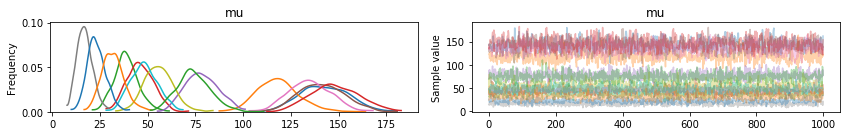

In [16]:
pm.traceplot(poisson_trace);

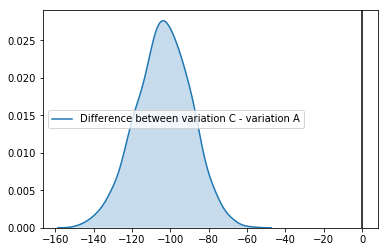

In [17]:
# Example: Difference between variation C and A
diff_CA = poisson_trace['mu'][:][:,2] - poisson_trace['mu'][:][:,0]
sns.kdeplot(diff_CA, shade = True, label = "Difference between variation C - variation A")
plt.axvline(0.0, color = 'black');

In [18]:
# Example of probability computations
print("Probability variation A gets more sign-ups than C:", (diff_CA < 0).mean())
print("Probability variation A gets less sign-ups than C:", (diff_CA > 0).mean())

Probability variation A gets more sign-ups than C: 1.0
Probability variation A gets less sign-ups than C: 0.0


Can you see how we can determine the best variation using this approach? Let us build a different model. 

## Beta-Binomial Model

Since we have no prior information about the true rates for each website, let us use $Uniform(0,1)$ as our prior distribution. We model the sign-ups as a [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) since our outcome is a Bernoulli process since the user either signs up or they do not).

More specifically, let $s_i$ be the number of sign-ups. We have that $s_i \sim Binomial(n_i, p_i)$ where $n_i$ is the number of trials and $p_i$ be the sign-up rate for banner variation $i$. Since the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is a generalization of the Uniform distribution, let $p_i \sim Beta(a,b)$. The hyper-parameters for the Beta distribution can also be from a prior distribution but this can make things overly complex. [Gelman et al. (2013)](http://www.stat.columbia.edu/~gelman/book/) discussed why we can assume the $f(a,b) \propto \frac{1}{(a+b)^{5/2}}$ where $a,b >0$ as the hyper-priors for the Beta-Binomial model.

## Question 2

Implement the Beta-Binomial hierarchical model discussed above and perform sampling:
<br><br>
<center>
$s_i \sim Binomial(n_i, p_i)$<br>
$p_i \sim Beta(a,b)$<br>
$f(a,b) \propto \frac{1}{(a+b)^{5/2}}$ where $a,b >0$
</center>

We implement the hyper-priors for the Beta distribution for you. Here are the steps which you need to perform:

* rates = pm.Beta():
    * Name the variable 'rates'
    * Set $a$ and $b$ to be the computed priors.
    * Set the shape to be the number of variations.
    * See the PyMC3 documentation for the [Beta Distribution](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Beta) for more details.
* observed_values = pm.Binomial():
    * Name the variable 'observed_values'
    * Set $n$ to be the 'click_count' from the DataFrame.
    * Set $p$ to be the 'rates' from the Beta distribution.
    * Set 'observed' to be the 'email_sign_up' column from the DataFrame.
    * See the PyMC3 documentation for the [Binomial Distribution](https://docs.pymc.io/api/distributions/discrete.html#pymc3.distributions.discrete.Binomial) for more details.
    
Obtain the trace by sampling with 1000 drawn samples and 100 tuning iterations. Your function should return both the model and the trace.

In [21]:
def binomial_beta_model(data):
    '''
    Build a Beta-Binomial Model for the web data
    
    Paramters
    ---------
    data: anpandas.DataFrame
    
    Returns
    -------
    bb_model: A pymc3.model.Model instance
    bb_trace: A pymc3.MultiTrace instance
    '''
    
    with pm.Model() as bb_model:

        # Implementation of Gelman's hyper-priors
        def hyperpriors(value):
            a = value[0]
            b = value[1]
            return T.switch(T.or_(T.le(a, 0), T.le(b, 0)), -np.inf, np.log(np.power((a + b), -2.5)))

        ab = pm.DensityDist('ab', hyperpriors, shape=2, testval=[1.0, 1.0])
        a = ab[0]
        b = ab[1]

    # YOUR CODE HERE
        rate = pm.Beta('rates', a, b,shape=len(data))
        observed_values = pm.Binomial('observed_values', n=data['click_count'],
                                     p=rate,observed=data['email_sign_up'])
        
        bb_trace = pm.sample(draws=1000, tune=100)
    
    return bb_model, bb_trace

In [22]:
# Build the model
bb_model, bb_trace = binomial_beta_model(web_ads)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 83.966:   5%|▌         | 10918/200000 [00:01<00:29, 6467.10it/s]
Convergence archived at 11400
Interrupted at 11,400 [5%]: Average Loss = 589.62
100%|██████████| 1100/1100 [00:05<00:00, 184.50it/s]


In [23]:
assert_true('ab' in dir(bb_model))
assert_true('rates' in dir(bb_model))
assert_true('observed_values' in dir(bb_model))
assert_equal(type(bb_model), pm.model.Model)
assert_equal(type(bb_model.ab), pm.model.FreeRV)
assert_equal(type(bb_model.rates), pm.model.TransformedRV)
assert_equal(type(bb_model.observed_values), pm.model.ObservedRV)
assert_equal(type(bb_trace), pm.backends.base.MultiTrace)
assert_true('ab' in bb_trace.varnames)
assert_true('rates' in bb_trace.varnames)

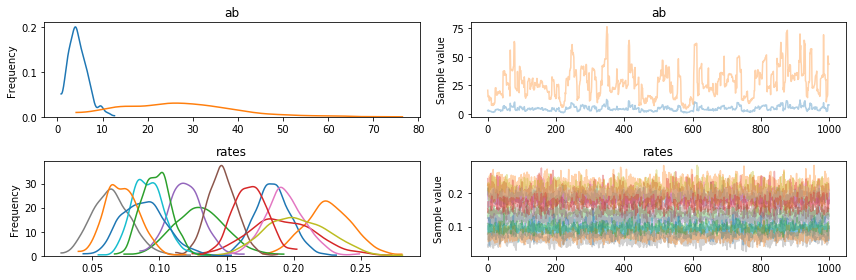

In [24]:
# Create the trace plot
pm.traceplot(bb_trace);

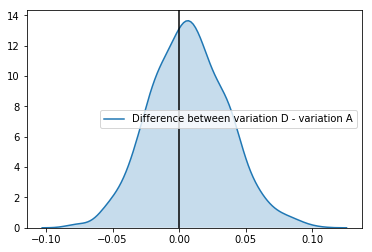

In [25]:
# Example: Difference between variation D and A
diff_DA = bb_trace['rates'][:][:,3] - bb_trace['rates'][:][:,0]
sns.kdeplot(diff_DA, shade = True, label = "Difference between variation D - variation A")
plt.axvline(0.0, color = 'black');

In [26]:
# Example of probability computations
print("Probability variation A gets more sign-ups than D:", (diff_DA < 0).mean())
print("Probability variation A gets less sign-ups than D:", (diff_DA > 0).mean())

Probability variation A gets more sign-ups than D: 0.402
Probability variation A gets less sign-ups than D: 0.598
